# 자전거 대여 수요 측정하기
## 데이터 필드
* datetime 
    - 연도-월-일-시간
* season 
    - 1 = 봄, 
    - 2 = 여름
    - 3 = 가을
    - 4 = 겨울 
* holiday 
    - 0 = 공휴일
    - 1= 비공휴일
* workingday
    - 0 = 평일(주말 또는 휴일 아님)
    - 1 = 평일 아님
* weather 
    - 1: 맑음 + 구름 거의 없음 + 구름 약간 
    - 2: 옅은 안개 + 구름 + 구름 약간과 옅은 안개 
    - 3: 가벼운 눈 또는 비 + 가벼운 비 후 개임 + 흐트러진 구름(scattered clouds) 
    - 4: 호우 + 빙판 + 뇌우 + 짙은 안개와 눈 + 짙은 안개
    - 1에서 4로 갈 수록 날씨가 좋지 않다
* temp 
    - 섭씨온도
* atemp
    - 체감온도
* humidity 
    - 습도
* windspeed 
    - 풍속
* casual 
    - 등록되지 않은 비회원의 대여 수
* registered 
    - 등록된 회원의 대여 수
* count 
    - 총 대여 수


## 평가 방식
제출 한 결과들은 RMSLE(Root Mean Squared Logarithmic Error)로 평가한다.
과대평가된 항목보다는, 과소평가된 항목에 패널티를 주는 평가 방식이다. 
값이 적을수록 오류가 적다는 것을 의미한다.
$$ \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 } $$


## 진행 단계
* 1) 훈련, 테스트 데이터셋의 형태 및 컬럼의 속성 데이터 값 파악
* 2) 데이터 전처리 및 시각화
* 3) 회귀모델 적용
* 4) 결론 도출

## -----------------------------------------------------------------------------------------------------------------------

## 1. 훈련, 테스트 데이터셋의 형태 및 컬럼의 속성 데이터 값 파악

In [234]:
# 필요 라이브러리들 호출

# warning을 무시
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# 데이터 시각화와 실험을 위해
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에 한글이 표시할 수 있기 위해
import platform
path = "c:/Windows/Fonts/HYGPRM.TTF"
from matplotlib import font_manager, rc
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~') 
    
# 그래프에서 마이너스부분이 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

In [235]:
# 훈련 데이터 셋과 테스트 데이터 셋을 불러온다
# 데이터 전처리 과정 중 datetime을 파싱해야하는 부분이 있어 parse_dates를 넣는다
train = pd.read_csv('../data/train.csv', parse_dates=["datetime"]) 
test = pd.read_csv('../data/test.csv', parse_dates=["datetime"])

# 훈련 데이터 셋을 df로, 테스트 데이터 셋을 test_df로 복사한다
df=train.copy()
test_df=test.copy()

In [236]:
# 훈련 데이터 셋의 개괄적인 모형 파악
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [237]:
# 훈련 데이터셋의 각 컬럼별 데이터 타입 및 값의 갯수 파악
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null datetime64[ns]
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.6 KB


In [238]:
df.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

각 컬럼 모두 비어있는 데이터 없이 모두 10886개의 데이터로 채워져있다

In [239]:
# 테스트 데이터 셋의 개괄적인 형태 출력
test_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [240]:
df.columns.unique()

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

훈련 데이터 셋과 달리, 테스트 데이터 셋에는 casual, registered, count 컬럼이 없다.

## 2.데이터 전처리 및 시각화

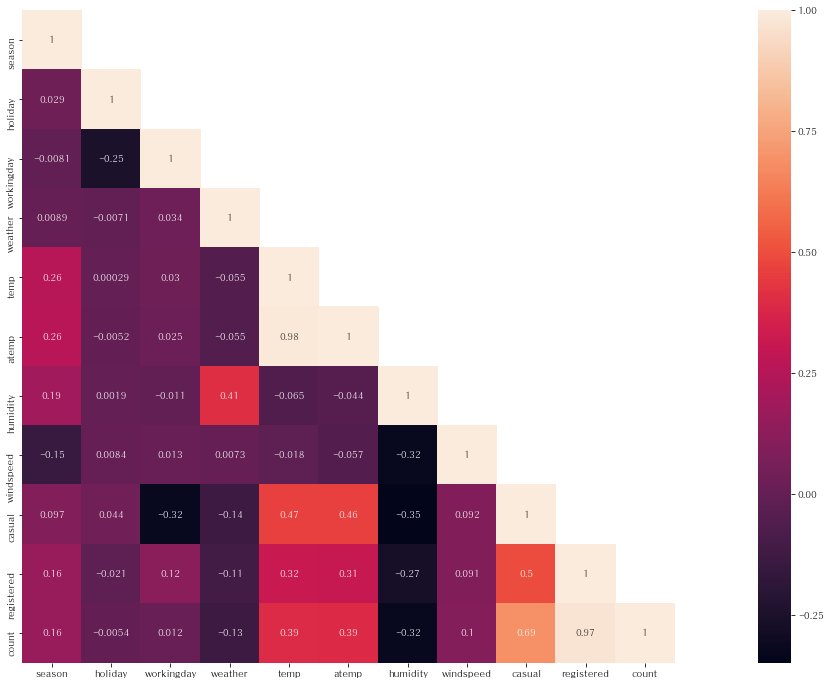

In [241]:
# 데이터 전처리를 진행하기 전에, 각 컬럼간의 연관관계를 시각화로 나타내보아
# 전처리 필요성을 느껴본다
cor_mat= df[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

* 검은쪽으로 진할 수록 연관관계가 낮다.
* 자기 자신과의 연관관계는 1이다.
* 온도, 습도, 풍속은 거의 연관관계가 없다. 
* 대여량과 가장 연관이 높은 건 registered 로 등록 된 대여자가 많지만, 테스트 데이터 셋에는 이 값이 없다.
* atemp와 temp는 0.98로 상관관계가 높지만 온도와 체감온도로 피처로 사용하기에 적합하지 않을 수 있다.
* 데이터 전처리를 하지 않은 상태에서 연관관계를 파악하기 힘들다.

### 1) datetime 파싱하기

In [242]:
# 년-월-일-시(hour) 를 분리한다
# 분(minute),초(second) 분리하지 않는 이유는 모든 데이터가 동일하게 0이기 때문이다

df["year"] = df["datetime"].dt.year
df["month"] = df["datetime"].dt.month
df["day"] = df["datetime"].dt.day
df["hour"] = df["datetime"].dt.hour

### 2) 요일 지정하기

In [243]:
# 요일에 따라 달라질 수 있으므로 컬럼을 추가한다
# 0:일 1:월 2:화 3:수 4:목 5:금 6:토
df["weekday"] = df["datetime"].dt.dayofweek 

In [244]:
# 추가한 컬럼들을 확인해본다
df.drop('datetime',axis=1,inplace=True)
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,weekday
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,5
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,5
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,5
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,5
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,5


[Text(0.5,0,'hour'), Text(0.5,1,'시간별 대여량')]

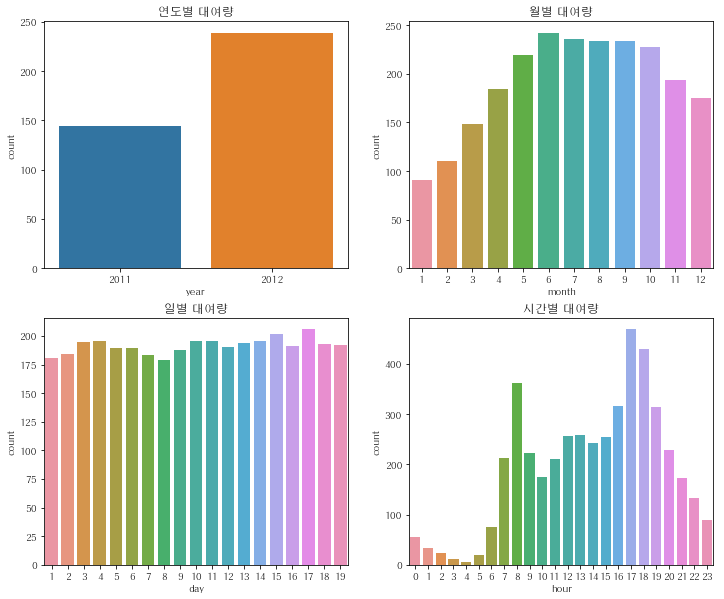

In [245]:
#각각의 속성과 예측의 결과값으로 쓰이는 count값과의 관계 파악

fig = plt.figure(figsize=[12,10])

#년도와 count
ax1 = fig.add_subplot(2,2,1)
ax1 = sns.barplot(x='year',y='count',data=df.groupby('year')['count'].mean().reset_index())
ax1.set(title="연도별 대여량")

#month와 count
ax2 = fig.add_subplot(2,2,2)
ax2 = sns.barplot(x='month',y='count',data=df.groupby('month')['count'].mean().reset_index())
ax2.set(title="월별 대여량")

#day와 count
ax3 = fig.add_subplot(2,2,3)
ax3 = sns.barplot(x='day',y='count',data=df.groupby('day')['count'].mean().reset_index())
ax3.set(title="일별 대여량")

#hour와 count
ax4 = fig.add_subplot(2,2,4)
ax4 = sns.barplot(x='hour',y='count',data=df.groupby('hour')['count'].mean().reset_index())
ax4.set(xlabel='hour', title="시간별 대여량")

- 연도별 대여량 : 2011년 보다 2012년이 더 많아 증가하였다.
- 월별 대여량 : 6월에 가장 많고, 7~10월도 많다. 1월이 가장 적다.
- 일별 대여량 : 1~19일 까지만 데이터가 존재하기 때문에 이 데이터는 피처로 사용할 수 없다.
- 시간별 대여량 : 출퇴근 시간에 가장 많다. 따라서, 주말의 데이터도 나누어 보아야할 것 같다.

[Text(0.5,1,'요일별 대여량')]

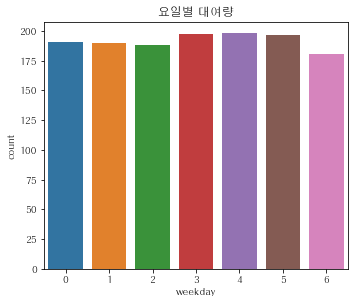

In [246]:
#요일과 count
fig = plt.figure(figsize=[12,10])

ax1 = fig.add_subplot(2,2,1)
ax1 = sns.barplot(x='weekday',y='count',data=df.groupby('weekday')['count'].mean().reset_index())
ax1.set(title="요일별 대여량")

* 요일별 대여량 : 서로 비슷한 대여량을 보이는데, 수,목,금요일이 가장 많고, 토요일이 가장 적다.

### 3) season 데이터 수정하기

In [248]:
# season에 이상이 있어 전처리

# 1월의 데이터에서 season 컬럼이 1, 즉 봄으로 나타나있다
# 데이터는 미국 워싱턴의 데이터로, 계절 변화가 우리나라와 비슷하다
# 따라서 1월은 겨울이므로 4, 즉 겨울로 바꿔야한다

def wrongSeason(month):
    if month in [12,1,2]:
        return 4
    elif month in [3,4,5]:
        return 1
    elif month in [6,7,8]:
        return 2
    elif month in [9,10,11]:
        return 3

df['season'] = df.month.apply(wrongSeason)

# 훈련 데이터셋을 출력한다
df.head()

,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,weekday,season
0,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,5,4
1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,5,4
2,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,5,4
3,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,5,4
4,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,5,4


[Text(0.5,1,'휴일 여부별 대여량')]

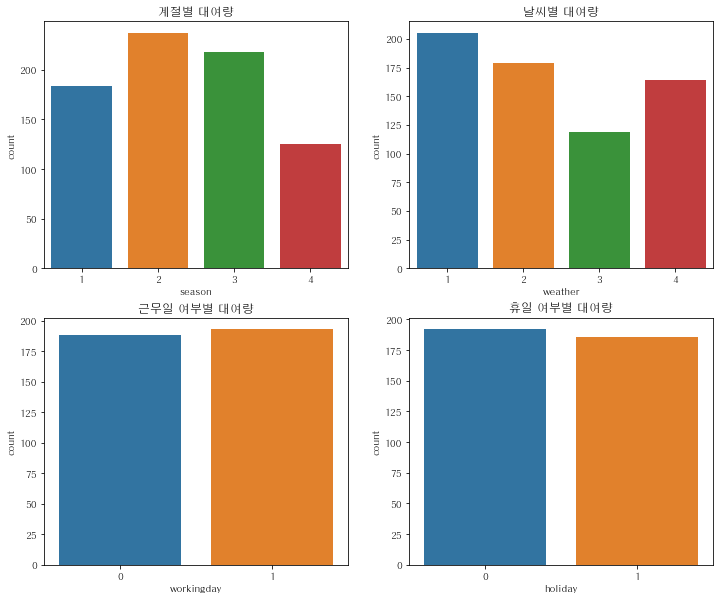

In [249]:
# 계절과 count
fig = plt.figure(figsize=[12,10])
ax1 = fig.add_subplot(2,2,1)
ax1 = sns.barplot(x='season',y='count',data=df.groupby('season')['count'].mean().reset_index())
ax1.set(title="계절별 대여량")

# 날씨와 count
ax2 = fig.add_subplot(2,2,2)
ax2 = sns.barplot(x='weather',y='count',data=df.groupby('weather')['count'].mean().reset_index())
ax2.set(title="날씨별 대여량")

# 근무일 여부와 count
ax3 = fig.add_subplot(2,2,3)
ax3 = sns.barplot(x='workingday',y='count',data=df.groupby('workingday')['count'].mean().reset_index())
ax3.set(title="근무일 여부별 대여량")

# 휴일 여부와 count
ax4 = fig.add_subplot(2,2,4)
ax4 = sns.barplot(x='holiday',y='count',data=df.groupby('holiday')['count'].mean().reset_index())
ax4.set(title="휴일 여부별 대여량")


* 계절과 날씨별 대여량은 각각 큰 차이가 보여진다.
* 하지만, 근무일과 휴일 여부별 대여량에는 큰 차이가 보이지 않는다.
* holiiday는 우리나라의 공휴일과 같다. 따라서 공휴일에는 주말이 포함되지 않지만, 근무일이 아니라는 개념에는 휴일과 주말이 포함되기때문에 근무일만 보는 것이 더 단순하다. 또한, 공휴일인지 주말인지로 대여량에 연관을 줄 것 같지 않아 보인다.

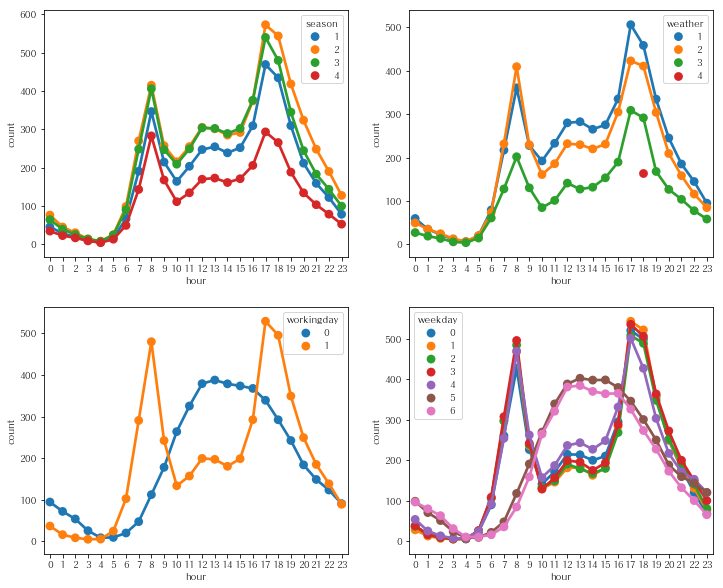

In [250]:
# 시간과 계절에 따른 count
fig = plt.figure(figsize=[12,10])
ax1 = fig.add_subplot(2,2,1)
ax1 = sns.pointplot(x='hour',y='count',hue='season',data=df.groupby(['season','hour'])['count'].mean().reset_index())

# 시간과 날씨에 따른 count
ax2 = fig.add_subplot(2,2,2)
ax2 = sns.pointplot(x='hour',y='count',hue='weather',data=df.groupby(['weather','hour'])['count'].mean().reset_index())

# 시간과 근무일 여부에 따른 count
ax3 = fig.add_subplot(2,2,3)
ax3 = sns.pointplot(x='hour',y='count',hue='workingday',data=df.groupby(['workingday','hour'])['count'].mean().reset_index())

# 시간과 요일 여부에 따른 count
ax4 = fig.add_subplot(2,2,4)
ax4 = sns.pointplot(x='hour',y='count',hue='weekday',data=df.groupby(['weekday','hour'])['count'].mean().reset_index())


- 계절별 대여량 : 여름과 가을에 가장 대여량이 많고, 겨울에 가장 대여량이 적다.
- 날씨별 대여량 : 날씨가 안좋을 수록 대여량이 적다. 가장 좋지 않은 날씨(4)는 드물어 하나의 점으로만 표시되었다.
- 근무일 여부별 대여량 : 근무일인 경우, 대여량이 출근시간(7-8시)와 퇴근시간(17-18시)가 가장 많았다. 근무일이 아닌 경우, 대여량이 점심시간(12-13시)가 가장 많았다.
- 요일별 대여량 : 근무일 여부별 대여량과 매우 흡사한 양상이 보여졌다. 

### 4) season 데이터 별로 컬럼 추가하기

In [251]:
# 4개의 컬럼을 추가하여 각 계절에 해당하는 컬럼에 1로 표현하고, 아닐 시 0로 표현한다
season=pd.get_dummies(df['season'],prefix='season')
df=pd.concat([df,season],axis=1)

### 5) weather 데이터 별로 컬럼 추가하기

In [252]:
# 4개의 컬럼을 추가하여 각 날씨에 해당하는 컬럼에 1로 표현하고, 아닐 시 0로 표현한다
weather=pd.get_dummies(df['weather'],prefix='weather')
df=pd.concat([df,weather],axis=1)

In [253]:
##추가된 컬럼 확인해보기 위해 훈련 데이터셋 출력
df.drop('season',axis=1,inplace=True)
df.drop('weather',axis=1,inplace=True)
df.head()

,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count,year,...,hour,weekday,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,0,0,9.84,14.395,81,0.0,3,13,16,2011,...,0,5,0,0,0,1,1,0,0,0
1,0,0,9.02,13.635,80,0.0,8,32,40,2011,...,1,5,0,0,0,1,1,0,0,0
2,0,0,9.02,13.635,80,0.0,5,27,32,2011,...,2,5,0,0,0,1,1,0,0,0
3,0,0,9.84,14.395,75,0.0,3,10,13,2011,...,3,5,0,0,0,1,1,0,0,0
4,0,0,9.84,14.395,75,0.0,0,1,1,2011,...,4,5,0,0,0,1,1,0,0,0


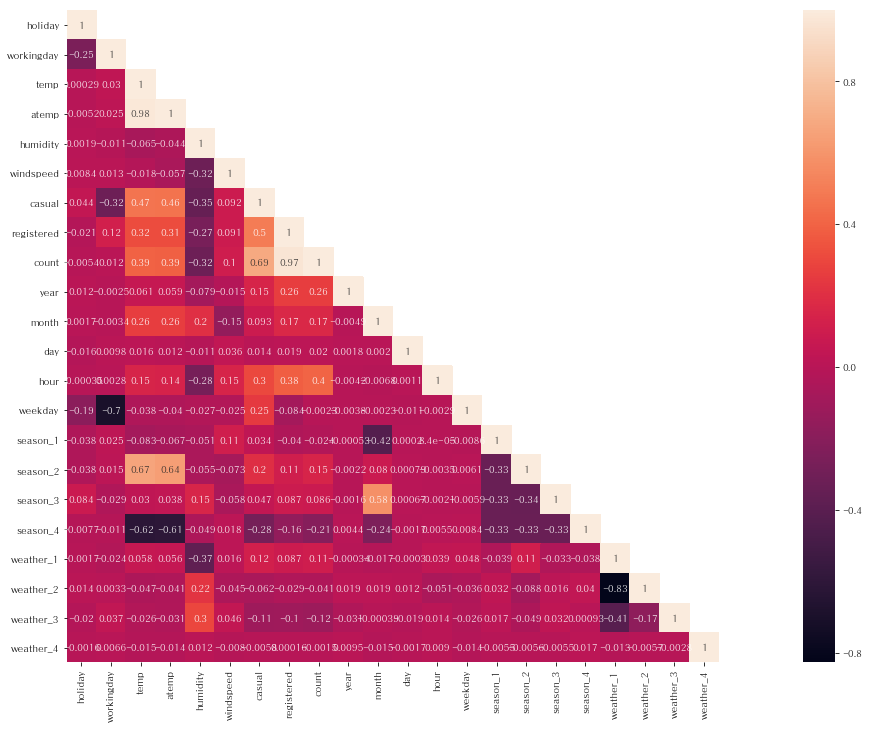

In [254]:
#각각의 컬럼들 간의 상관계수를 heatmap을 통해 시각화

cor_mat= df[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

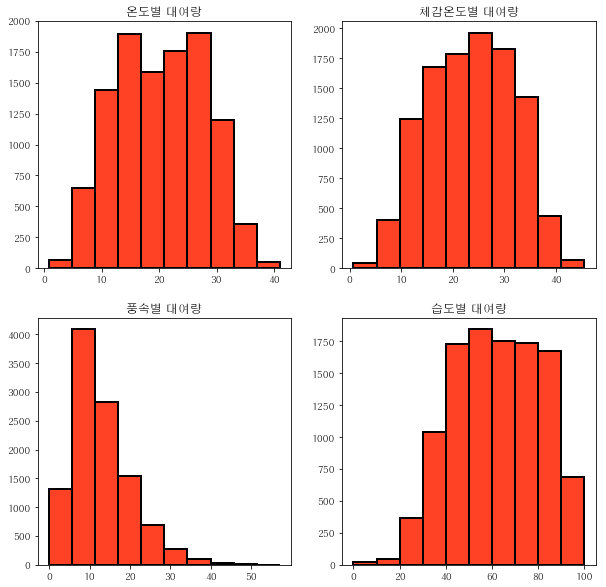

In [255]:
# 다른 컬럼들과 count와 비교

train.temp.unique()
fig,axes=plt.subplots(2,2)

# 온도와 count
axes[0,0].hist(x="temp",data=train,edgecolor="black",linewidth=2,color='#ff4125')
axes[0,0].set_title("온도별 대여랑")
# 체감온도와 count
axes[0,1].hist(x="atemp",data=train,edgecolor="black",linewidth=2,color='#ff4125')
axes[0,1].set_title("체감온도별 대여량")
# 풍속과 count
axes[1,0].hist(x="windspeed",data=train,edgecolor="black",linewidth=2,color='#ff4125')
axes[1,0].set_title("풍속별 대여량")
# 습도와 count
axes[1,1].hist(x="humidity",data=train,edgecolor="black",linewidth=2,color='#ff4125')
axes[1,1].set_title("습도별 대여량")
fig.set_size_inches(10,10)

* 풍속의 경우 0에 숫자가 몰려 있는 것으로 보인다. 아마도 관측되지 않은 수치에 대해 0으로 기록된 것이 아닐까 추측해 본다.

## 모든 동일한 전처리 과정을 테스트 셋에 진행

In [257]:
# datetime 파싱하기
test_df["year"] = test_df["datetime"].dt.year
test_df["month"] = test_df["datetime"].dt.month
test_df["day"] = test_df["datetime"].dt.day
test_df["hour"] = test_df["datetime"].dt.hour

In [258]:
# 요일 지정하기
test_df["weekday"] = test_df["datetime"].dt.dayofweek 

In [259]:
# season 데이터 수정하기
test_df['season'] = test_df.month.apply(wrongSeason)

In [260]:
# season 데이터 별로 컬럼 추가하기
season=pd.get_dummies(test_df['season'],prefix='season')
test_df=pd.concat([test_df,season],axis=1)

In [261]:
# weather 데이터 별로 컬럼 추가하기
weather=pd.get_dummies(test_df['weather'],prefix='weather')
test_df=pd.concat([test_df,weather],axis=1)

In [262]:
# 전처리를 끝냈기 때문에 원래의 컬럼 삭제
test_df.drop('datetime',axis=1,inplace=True)
test_df.drop('season',axis=1,inplace=True)
test_df.drop('weather',axis=1,inplace=True)

In [263]:
test_df.head()

,holiday,workingday,temp,atemp,humidity,windspeed,year,month,day,hour,weekday,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,0,1,10.66,11.365,56,26.0027,2011,1,20,0,3,0,0,0,1,1,0,0,0
1,0,1,10.66,13.635,56,0.0000,2011,1,20,1,3,0,0,0,1,1,0,0,0
2,0,1,10.66,13.635,56,0.0000,2011,1,20,2,3,0,0,0,1,1,0,0,0
3,0,1,10.66,12.880,56,11.0014,2011,1,20,3,3,0,0,0,1,1,0,0,0
4,0,1,10.66,12.880,56,11.0014,2011,1,20,4,3,0,0,0,1,1,0,0,0


## 6) windspeed가 0인 데이터 처리하기
* 랜덤 포레스트 모델을 이용하여 해결한다

In [264]:
combine = pd.concat([df,test_df],axis=0)

In [266]:
combine.head()

,atemp,casual,count,day,holiday,hour,humidity,month,registered,season_1,...,season_4,temp,weather_1,weather_2,weather_3,weather_4,weekday,windspeed,workingday,year
0,14.395,3.0,16.0,1,0,0,81,1,13.0,0,...,1,9.84,1,0,0,0,5,0.0,0,2011
1,13.635,8.0,40.0,1,0,1,80,1,32.0,0,...,1,9.02,1,0,0,0,5,0.0,0,2011
2,13.635,5.0,32.0,1,0,2,80,1,27.0,0,...,1,9.02,1,0,0,0,5,0.0,0,2011
3,14.395,3.0,13.0,1,0,3,75,1,10.0,0,...,1,9.84,1,0,0,0,5,0.0,0,2011
4,14.395,0.0,1.0,1,0,4,75,1,1.0,0,...,1,9.84,1,0,0,0,5,0.0,0,2011
